Introduction
=======
This notebook is the computational appendix to arXiv:1505.03837. We detail how to obtain the numerical results.

To run this notebook, the dependencies are [NumPy](http://www.numpy.org/), [MatPlotLib](http://matplotlib.org/), [QuTip](http://www.qutip.org), [SymPy](http://www.sympy.org), and [Ncpol2sdpa](http://peterwittek.github.io/ncpol2sdpa/)>=1.7. Furthermore, to solve the semidefinite programmes (SDPs), a member of the [SDPA](http://sdpa.sourceforge.net/download.html) family of solvers must be in the path.

As a first step, we import all necessary functions:

In [1]:
from math import atan
import matplotlib.pyplot as plt
from numpy import *
from qutip import *
from ncpol2sdpa import *

Maximum guessing probability with the elegant inequality and a POVM
------------------------------------------------------------------------------------------
First we set the Bell scenario: Alice has three dichotomic measurements and one four-output POVM. Bob has four dichotomic measurements. We replicate the elegant Bell inequality [1] in the Collins-Gisin notation [2], leaving blank spaces for Alice's POVM:

In [2]:
A_configuration = [2, 2, 2, 4]
B_configuration = [2, 2, 2, 2]
I = [[ 0, -1.5, 0.5, 0.5,  0.5],
     [ 0,    1,   1,  -1,   -1],
     [ 0,    1,  -1,   1,   -1],
     [ 0,    1,  -1,  -1,    1],
     [ 0,    0,   0,   0,    0],
     [ 0,    0,   0,   0,    0],
     [ 0,    0,   0,   0,    0]]

Next we define the algebra of the measurement operators:

In [3]:
A = generate_measurements(A_configuration, 'A')
B = generate_measurements(B_configuration, 'B')
substitutions = projective_measurement_constraints(A, B)

We are looking for the maximum guessing probability, so the constraint will be the Bell inequality which also includes the POVM tetrahedron. The tetrahedron coefficients have a $k$ parameter, but the numerical calculations are insensitive to it. Since we want the Bell inequality to match the maximum violation, we add a pair of inequality constraints.

In [4]:
k = 1.0
bell_inequality = - define_objective_with_I(I, A, B) - \
                      k*(A[3][0]*B[0][0] + A[3][1]*B[1][0] + A[3][2]*B[2][0] +
                      (1-A[3][0]-A[3][1]-A[3][2])*B[3][0])
bounds = [-sqrt(3) + bell_inequality, sqrt(3) - bell_inequality]

The objective is the maximum guessing probability. The SDPA solver can only minimize, so we flip the sign. It is sufficient to study one output, as the results are symmetric in the POVM.

In [5]:
objective = - A[3][0]

Here we give an example of a level 2+AAB+ABB relaxation. Higher level relaxations are straightforward generalization of this. Obtaining the relaxation can take a few minutes.

In [6]:
level = 2
AAB = [Ak*Ai*Bj for Ak in flatten(A) for Ai in flatten(A) for Bj in flatten(B)]
ABB = [Ak*Bi*Bj for Ak in flatten(A) for Bi in flatten(B) for Bj in flatten(B)]
sdpRelaxation = SdpRelaxation(flatten([A, B]))
sdpRelaxation.get_relaxation(level, objective=objective,
                             bounds = bounds,
                             substitutions=substitutions,
                             extramonomials = flatten([AAB, ABB]))

Solving the SDP takes another few minutes.

In [7]:
print(solve_sdp(sdpRelaxation))

(-0.25142027977524845, -0.2507110638510907)


The regular-precision solver will not give an accurate result, it will yield a large gap between the primal and dual. To solve the problem with higher precision, we export it to a file.

In [8]:
write_to_sdpa(sdpRelaxation, "elegant_povm.dat-s")

Oddly, solving this with the arbitrary-precision solver SDPA_GMP or the quad-double-precision solver SDPA_QD will lead to divergent results. This is due to the constraint that involves $\sqrt{3}$. It is written to the file at regular double precision, which leads to the divergent behaviour with the higher precision solvers. To rectify the problem, the file can be manually edited to include $\sqrt{3}$ at a higher precision. We used six extra digits, that is, $1.7320508075688772$. With this setting, we get $0.25$ up to $10^{-8}$ precision at this level of relaxation using the quad-double-precision solver, with a relative gap between the primal and dual on the order of $10^{-57}$.

Noise sensitivity of the analytical result
--------------------------------------------------------
We analyze the noise sensitivity using the full correlations [1], therefore we need a function that generates a behaviour for a given state and a measurement. For convenience, we define a function to calculate the dot product $\vec{\sigma}\vec{v}$.

In [2]:
def dp(v, sigma):
    result = v[0]*sigma[0]
    for i in range(1, 3):
        result += v[i]*sigma[i]
    return result

Next we define the joint probability as the function of $p$ the parameter in a Werner state. The measurements correspond to the ones described in the manuscript, with the POVM being the tetrahedron.

In [3]:

def joint_probabilities(p):
    psi = (tensor(basis(2,0),basis(2,0)) + tensor(basis(2,1),basis(2,1))).unit()
    rho = Qobj(p*(psi*psi.dag()).data+(1-p)*qeye(4).data/4, dims=[[2,2], [2,2]])
    A_00 = (qeye(2)+sigmaz())/2
    A_10 = (qeye(2)+sigmax())/2
    A_20 = (qeye(2)+sigmay())/2

    B_00 = (qeye(2)+(sigmaz()+sigmax())/sqrt(2))/2
    B_10 = (qeye(2)+(sigmaz()-sigmax())/sqrt(2))/2
    B_20 = (qeye(2)+(sigmaz()-sigmay())/sqrt(2))/2
    B_30 = (qeye(2)+(sigmaz()+sigmay())/sqrt(2))/2
    B_40 = (qeye(2)+(sigmax()-sigmay())/sqrt(2))/2
    B_50 = (qeye(2)+(sigmax()+sigmay())/sqrt(2))/2

    b = [array([ 1, -1, -1])/sqrt(3),
         array([-1, -1,  1])/sqrt(3),
         array([ 1,  1,  1])/sqrt(3),
         array([-1,  1, -1])/sqrt(3)]
    B_6= [(qeye(2)+dp(bj, [sigmax(), sigmay(), sigmaz()]))/4 for bj in b]

    probabilities = [expect(tensor(A_00, qeye(2)), rho),
                     expect(tensor(A_10, qeye(2)), rho),
                     expect(tensor(A_20, qeye(2)), rho),
 
                     expect(tensor(qeye(2), B_00), rho),
                     expect(tensor(qeye(2), B_10), rho),
                     expect(tensor(qeye(2), B_20), rho),
                     expect(tensor(qeye(2), B_30), rho),
                     expect(tensor(qeye(2), B_40), rho),
                     expect(tensor(qeye(2), B_50), rho),
                     expect(tensor(qeye(2), B_6[0]), rho),
                     expect(tensor(qeye(2), B_6[1]), rho),
                     expect(tensor(qeye(2), B_6[2]), rho),

                     expect(tensor(A_00, B_00), rho),
                     expect(tensor(A_00, B_10), rho),
                     expect(tensor(A_00, B_20), rho),
                     expect(tensor(A_00, B_30), rho),
                     expect(tensor(A_00, B_40), rho),
                     expect(tensor(A_00, B_50), rho),
                     expect(tensor(A_00, B_6[0]), rho),
                     expect(tensor(A_00, B_6[1]), rho),
                     expect(tensor(A_00, B_6[2]), rho),

                     expect(tensor(A_10, B_00), rho),
                     expect(tensor(A_10, B_10), rho),
                     expect(tensor(A_10, B_20), rho),
                     expect(tensor(A_10, B_30), rho),
                     expect(tensor(A_10, B_40), rho),
                     expect(tensor(A_10, B_50), rho),
                     expect(tensor(A_10, B_6[0]), rho),
                     expect(tensor(A_10, B_6[1]), rho),
                     expect(tensor(A_10, B_6[2]), rho),

                     expect(tensor(A_20, B_00), rho),
                     expect(tensor(A_20, B_10), rho),
                     expect(tensor(A_20, B_20), rho),
                     expect(tensor(A_20, B_30), rho),
                     expect(tensor(A_20, B_40), rho),
                     expect(tensor(A_20, B_50), rho),
                     expect(tensor(A_20, B_6[0]), rho),
                     expect(tensor(A_20, B_6[1]), rho),
                     expect(tensor(A_20, B_6[2]), rho)]

    return probabilities

We formally define the scenario and the projector algebra again. The difference is that in the full-probability picture, the maximum guessing probability may not be extremal. Hence we construct four separate algebras, corresponding to the four outputs.

In [4]:
A_configuration = [2, 2, 2]
B_configuration = [2, 2, 2, 2, 2, 2, 4]

P_0_A = generate_measurements(A_configuration, 'P_0_A')
P_0_B = generate_measurements(B_configuration, 'P_0_B')
substitutions1 = projective_measurement_constraints(P_0_A, P_0_B)
P_1_A = generate_measurements(A_configuration, 'P_1_A')
P_1_B = generate_measurements(B_configuration, 'P_1_B')
substitutions2 = projective_measurement_constraints(P_1_A, P_1_B)
P_2_A = generate_measurements(A_configuration, 'P_2_A')
P_2_B = generate_measurements(B_configuration, 'P_2_B')
substitutions3 = projective_measurement_constraints(P_2_A, P_2_B)
P_3_A = generate_measurements(A_configuration, 'P_3_A')
P_3_B = generate_measurements(B_configuration, 'P_3_B')
substitutions4 = projective_measurement_constraints(P_3_A, P_3_B)
substitutions = dict(substitutions1.items() + substitutions2.items() +
                     substitutions3.items() + substitutions4.items())

The guessing probability in this case is the sum of the POVM outcomes. Since we work in the Collins-Gisin notation, the last outcome of a measurement is not included in the algebra. This can easily be constructed by deducting the rest of the operators in a measurement from the identity. This, however, is more complicated here, because each algebra generates a moment matrix, and the top left is not the expectation value with the identity operator. So instead, we will have to include a special variable in the objective function, the top left element of the last moment matrix.

In [5]:
guessing_probability = -(P_0_B[6][0] + P_1_B[6][1] + P_2_B[6][2] + 
                         (-P_3_B[6][0]-P_3_B[6][1]-P_3_B[6][2]))
extraobjexpr="-3[0,0]"

We do a level 2 relaxation.

In [13]:
level=2
sdpRelaxation = SdpRelaxation([flatten([P_0_A, P_0_B]),
                               flatten([P_1_A, P_1_B]),
                               flatten([P_2_A, P_2_B]),
                               flatten([P_3_A, P_3_B])],
                               normalized=False)

The following function obtains the probabilities and defines the constraint $\sum_a p_a=p$. It also normalizes the top-left elements of the four moment matrices. On its first call it obtains the relaxation, and in subsequent calls, it simply replaces the constraints and solves the SDP. 

In [14]:
def get_maximum_guessing_probability(p, first=False):
    probabilities = joint_probabilities(p)

    bounds = []
    k=0
    #Marginals first
    for i in range(3):
        bounds.append(P_0_A[i][0]+P_1_A[i][0]+P_2_A[i][0]+P_3_A[i][0]-probabilities[k])
        k += 1
    for j in range(6):
        bounds.append(P_0_B[j][0]+P_1_B[j][0]+P_2_B[j][0]+P_3_B[j][0]-probabilities[k])
        k += 1
    for j in range(3):
        bounds.append(P_0_B[6][j]+P_1_B[6][j]+P_2_B[6][j]+P_3_B[6][j]-probabilities[k])
        k += 1

    #Joint probabilities
    for i in range(3):
        for j in range(6):
            bounds.append(P_0_A[i][0]*P_0_B[j][0]+P_1_A[i][0]*P_1_B[j][0]+P_2_A[i][0]*P_2_B[j][0]+P_3_A[i][0]*P_3_B[j][0]-probabilities[k])
            k += 1
        for j in range(3):
            bounds.append(P_0_A[i][0]*P_0_B[6][j]+P_1_A[i][0]*P_1_B[6][j]+P_2_A[i][0]*P_2_B[6][j]+P_3_A[i][0]*P_3_B[6][j]-probabilities[k])
            k += 1
    # The bounds are all inequalities, so we also have to add their negative
    # counterparts to force the equalities
    bounds.extend([-bound for bound in bounds])
    # We need to normalize the top-left elements of the moment matrices
    bounds.extend(["0[0,0]+1[0,0]+2[0,0]+3[0,0]-1", "-0[0,0]-1[0,0]-2[0,0]-3[0,0]+1"])
    if first:
        sdpRelaxation.get_relaxation(level, objective=guessing_probability,
                                     bounds=bounds,
                                     substitutions=substitutions,
                                     extraobjexpr=extraobjexpr)
    else:
        sdpRelaxation.process_constraints(bounds=bounds)

    primal, dual = solve_sdp(sdpRelaxation)
    return -primal

We call this function over a range of values to obtain the results. This can take over half an hour to calculate.

In [15]:
noise = [1.0, 0.999, 0.99, 0.95, 0.925, 0.9, 0.875, 0.85]
sensitivity = [get_maximum_guessing_probability(noise[0], first = True)]
for p in noise[1:]:
    sensitivity.append(get_maximum_guessing_probability(p))
print(sensitivity)

[0.2993497343227554, 0.4323495242641335, 0.5571038404153698, 0.7655105378305733, 0.8583245046254272, 0.941178160783859, 1.0000001228996722, 1.0000001317411034]


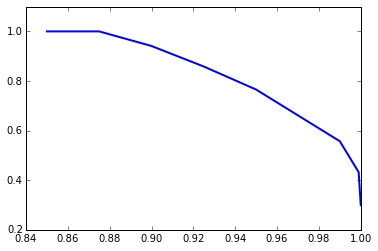

In [16]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(noise, sensitivity, linewidth=2)

Noise sensitivity of the [(2, 2, 2, 4) (2, 2, 2, 2)] scenario
---------------------------------------------------------------------------------
The case is very similar to the previous one. First we define the joint probability:

In [17]:
def joint_probabilities(p):
    psi = (tensor(basis(2,0),basis(2,0)) + tensor(basis(2,1),basis(2,1))).unit()
    rho = Qobj(p*(psi*psi.dag()).data+(1-p)*qeye(4).data/4, dims=[[2,2], [2,2]])
    A_00 = (qeye(2)+sigmaz())/2
    A_10 = (qeye(2)+sigmax())/2
    A_20 = (qeye(2)+sigmay())/2
    sigma = [sigmax(), sigmay(), sigmaz()]
    b = [array([ 1, -1, -1])/sqrt(3),
         array([-1, -1,  1])/sqrt(3),
         array([ 1,  1,  1])/sqrt(3),
         array([-1,  1, -1])/sqrt(3)]
    A_3 = [(qeye(2)+dp(bj, sigma))/4 for bj in b]

    B_00 = (qeye(2)+dp([ 1, -1,  1], sigma)/sqrt(3))/2
    B_10 = (qeye(2)+dp([-1,  1,  1], sigma)/sqrt(3))/2
    B_20 = (qeye(2)+dp([ 1,  1, -1], sigma)/sqrt(3))/2
    B_30 = (qeye(2)+dp([-1, -1, -1], sigma)/sqrt(3))/2

    probabilities = [expect(tensor(A_00, qeye(2)), rho),
                     expect(tensor(A_10, qeye(2)), rho),
                     expect(tensor(A_20, qeye(2)), rho),
                     expect(tensor(A_3[0], qeye(2)), rho),
                     expect(tensor(A_3[1], qeye(2)), rho),
                     expect(tensor(A_3[2], qeye(2)), rho),

                     expect(tensor(qeye(2), B_00), rho),
                     expect(tensor(qeye(2), B_10), rho),
                     expect(tensor(qeye(2), B_20), rho),
                     expect(tensor(qeye(2), B_30), rho),

                     expect(tensor(A_00, B_00), rho),
                     expect(tensor(A_00, B_10), rho),
                     expect(tensor(A_00, B_20), rho),
                     expect(tensor(A_00, B_30), rho),

                     expect(tensor(A_10, B_00), rho),
                     expect(tensor(A_10, B_10), rho),
                     expect(tensor(A_10, B_20), rho),
                     expect(tensor(A_10, B_30), rho),

                     expect(tensor(A_20, B_00), rho),
                     expect(tensor(A_20, B_10), rho),
                     expect(tensor(A_20, B_20), rho),
                     expect(tensor(A_20, B_30), rho),

                     expect(tensor(A_3[0], B_00), rho),
                     expect(tensor(A_3[0], B_10), rho),
                     expect(tensor(A_3[0], B_20), rho),
                     expect(tensor(A_3[0], B_30), rho),

                     expect(tensor(A_3[1], B_00), rho),
                     expect(tensor(A_3[1], B_10), rho),
                     expect(tensor(A_3[1], B_20), rho),
                     expect(tensor(A_3[1], B_30), rho),

                     expect(tensor(A_3[2], B_00), rho),
                     expect(tensor(A_3[2], B_10), rho),
                     expect(tensor(A_3[2], B_20), rho),
                     expect(tensor(A_3[2], B_30), rho)]

    return probabilities

Next we define the algebra, the objective function, and we formally initialize the level-2 relaxation.

In [18]:
A_configuration = [2, 2, 2, 4]
B_configuration = [2, 2, 2, 2]
P_0_A = generate_measurements(A_configuration, 'P_0_A')
P_0_B = generate_measurements(B_configuration, 'P_0_B')
substitutions1 = projective_measurement_constraints(P_0_A, P_0_B)
P_1_A = generate_measurements(A_configuration, 'P_1_A')
P_1_B = generate_measurements(B_configuration, 'P_1_B')
substitutions2 = projective_measurement_constraints(P_1_A, P_1_B)
P_2_A = generate_measurements(A_configuration, 'P_2_A')
P_2_B = generate_measurements(B_configuration, 'P_2_B')
substitutions3 = projective_measurement_constraints(P_2_A, P_2_B)
P_3_A = generate_measurements(A_configuration, 'P_3_A')
P_3_B = generate_measurements(B_configuration, 'P_3_B')
substitutions4 = projective_measurement_constraints(P_3_A, P_3_B)
substitutions = dict(substitutions1.items() + substitutions2.items() +
                     substitutions3.items() + substitutions4.items())
guessing_probability = -(P_0_A[3][0] + P_1_A[3][1] + P_2_A[3][2] + (-P_3_A[3][0]-P_3_A[3][1]-P_3_A[3][2]))
extraobjexpr="-3[0,0]"
level=2
sdpRelaxation = SdpRelaxation([flatten([P_0_A, P_0_B]),
                               flatten([P_1_A, P_1_B]),
                               flatten([P_2_A, P_2_B]),
                               flatten([P_3_A, P_3_B])],
                               normalized=False)

We need to define the function to get the maximum guessing probability again.

In [19]:
def get_maximum_guessing_probability(p, first=False):
    probabilities = joint_probabilities(p)

    bounds = []
    k=0
    #Marginals first
    for i in range(3):
        bounds.append(P_0_A[i][0]+P_1_A[i][0]+P_2_A[i][0]+P_3_A[i][0]-probabilities[k])
        k += 1
    for j in range(3):
        bounds.append(P_0_A[3][j]+P_1_A[3][j]+P_2_A[3][j]+P_3_A[3][j]-probabilities[k])
        k += 1
    for j in range(4):
        bounds.append(P_0_B[j][0]+P_1_B[j][0]+P_2_B[j][0]+P_3_B[j][0]-probabilities[k])
        k += 1

    #Joint probabilities
    for i in range(3):
        for j in range(4):
            bounds.append(P_0_A[i][0]*P_0_B[j][0]+P_1_A[i][0]*P_1_B[j][0]+P_2_A[i][0]*P_2_B[j][0]+P_3_A[i][0]*P_3_B[j][0]-probabilities[k])
            k += 1
    for i in range(3):
        for j in range(4):
            bounds.append(P_0_A[3][i]*P_0_B[j][0]+P_1_A[3][i]*P_1_B[j][0]+P_2_A[3][i]*P_2_B[j][0]+P_3_A[3][i]*P_3_B[j][0]-probabilities[k])
            k += 1
    # The bounds are all inequalities, so we also have to add their negative
    # counterparts to force the equalities
    bounds.extend([-bound for bound in bounds])
    # We need to normalize the top-left elements of the moment matrices
    bounds.extend(["0[0,0]+1[0,0]+2[0,0]+3[0,0]-1", "-0[0,0]-1[0,0]-2[0,0]-3[0,0]+1"])
    if first:
        sdpRelaxation.get_relaxation(level, objective=guessing_probability,
                                     bounds=bounds,
                                     substitutions=substitutions,
                                     extraobjexpr=extraobjexpr)
    else:
        sdpRelaxation.process_constraints(bounds=bounds)

    primal, dual = solve_sdp(sdpRelaxation)
    return -primal

The rest of the solution is identical.

In [20]:
noise = [1.0, 0.999, 0.99, 0.95, 0.925, 0.9, 0.875, 0.85]
sensitivity = [get_maximum_guessing_probability(noise[0], first = True)]
for p in noise[1:]:
    sensitivity.append(get_maximum_guessing_probability(p))
print(sensitivity)

[0.2554685918218898, 0.33975489082800414, 0.4919566107394366, 0.7454076795571081, 0.8755871394706972, 1.0000001215838104, 1.0000007698657265, 1.0000004906621798]


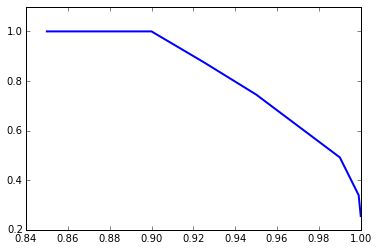

In [21]:
plt.plot(noise, sensitivity, linewidth=2)

Global randomness in the [(2, 2, 2, 2, 2, 2, 2, 4) (2, 2, 2, 2, 2, 2, 2, 4)] scenario
------------------------------------------------------------------------------------------------------------------
For the global randomness, we use a specific Bell inequality, defined by the following matrix in the Collins-Gisin picture:

In [22]:
delta = 0.0676946837698
k = 1.0
I= [[      0,          -0.5,      -0.5,      -0.5, -(1+delta)/2, -(1-delta)/2,-(-1+delta)/2,-(-1-delta)/2-k,    0,    0,     0],
    [   -0.5,             1,         0,         0,            1,            1,           -1,             -1,    0,    0,     0],
    [   -0.5,             0,         1,         0,        delta,       -delta,            0,              0,    0,    0,     0],
    [   -0.5,             0,         0,         1,            0,            0,        delta,         -delta,    0,    0,     0],
    [  -(1+delta)/2,  delta,         0,         1,            0,            0,            0,              0,   -k,    0,     0],
    [  -(1-delta)/2, -delta,         0,         1,            0,            0,            0,              0,    0,   -k,     0],
    [  -(-1+delta)/2,     0,     delta,        -1,            0,            0,            0,              0,    0,    0,    -k],
    [  -(-1-delta)/2-k,   0,    -delta,        -1,            0,            0,            0,              0,    k,    k,     k],
    [      0,             0,         0,         0,           -k,            0,            0,              k,    0,    0,     0],
    [      0,             0,         0,         0,            0,           -k,            0,              k,    0,    0,     0],
    [      0,             0,         0,         0,            0,            0,           -k,              k,    0,    0,     0]]

We obtained the $\delta$ value by nonconvex optimization. Defining the operators is straightforward:

In [23]:
A_configuration = [2, 2, 2, 2, 2, 2, 2, 4]
B_configuration = [2, 2, 2, 2, 2, 2, 2, 4]
A = generate_measurements(A_configuration, 'A')
B = generate_measurements(B_configuration, 'B')
AB = [Ai*Bj for Ai in flatten(A) for Bj in flatten(B)]
substitutions = projective_measurement_constraints(A, B)

We impose the maximum violation as a constraint and optimize for the guessing probability. The guessing probability is symmetric for all joint output of the POVM, hence it is enough to look at the first pair.

In [24]:
level = 1
equality = -define_objective_with_I(I, A, B) - ((3.0+8.0*sqrt(1+delta**2)-11)/4+2)
sdpRelaxation = SdpRelaxation(flatten([A, B]), verbose=2)
sdpRelaxation.get_relaxation(level, substitutions=substitutions, objective = -A[7][0]*B[7][0],
                             equalities=[equality], extramonomials = AB)
primal, dual = solve_sdp(sdpRelaxation)
print primal, dual

Calculating block structure...
Estimated number of SDP variables: 7380
Generating moment matrix...
Reduced number of SDP variables: 4572
Processing 2/2 constraints...
-0.145292760254 -0.139210070958


The gap between the primal and dual solution is large. Solving the above SDP with SeDuMi provides a smaller gap with the value reported in the manuscript. Exporting the SDP is done with the following command:

In [25]:
write_to_sdpa(sdpRelaxation, "global_randomness.dat-s")

References
-----------
[1] Gisin, N. [Bell inequalities: Many questions, a few answers](http://arxiv.org/abs/quant-ph/0702021). *Quantum Reality, Relativistic Causality, and Closing the Epistemic Circle*, Springer Netherlands, 2009, 73, 125--138.

[2] Collins, D. & Gisin, N. [A relevant two qubit Bell inequality inequivalent to the CHSH inequality](http://arxiv.org/abs/quant-ph/0306129). *Journal of Physics A: Mathematical and General*, IOP Publishing, 2004, 37, 1775.

[3] Nieto-Silleras, O.; Pironio, S. & Silman, J. [Using complete measurement statistics for optimal device-independent randomness evaluation](http://arxiv.org/abs/1309.3930). *New Journal of Physics*, 2014, 16, 013035.